# Navigate along a corridor with one obstacle: learning

In this notebook we try to learn a policy to navigate in a corridor with one obstacle.
We fix the model (an MLP with two layers with 128 neurons) and applies three learning algorithms,
providing during training more or less the same number of simulation steps:

- Behavioral cloning (IL)
- DAgger (IL)
- SAC (RL)

In [1]:
import numpy as np
from navground import core, sim
from navground_learning.scenarios.corridor_with_obstacle import CorridorWithObstacle

In [2]:
import datasets.utils
import tqdm.autonotebook
import imitation.algorithms.bc

datasets.utils.tqdm = tqdm.autonotebook.tqdm
imitation.algorithms.bc.tqdm = tqdm.autonotebook
datasets.utils.disable_progress_bar()

In [3]:
import numpy as np
import gymnasium as gym
from navground import core, sim
from navground_learning.scenarios.corridor_with_obstacle import CorridorWithObstacle
from navground_learning import ControlActionConfig, ObservationConfig
from navground_learning.reward import SocialReward
from navground_learning.il.utils import make_venv

scenario = sim.load_scenario("""
type: CorridorWithObstacle
length: 1.0
width: 1.0
min_radius: 0.2
max_radius: 0.2
groups:
  -
    type: thymio
    number: 1
    radius: 0.08
    control_period: 0.05
    color: gold
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 10
      tau: 0.25
      eta: 0.5
      safety_margin: 0.05
      barrier_angle: 1.0
    state_estimation:
      type: Bounded
      range: 1.0
      update_static_obstacles: true
""")

sensor = sim.load_state_estimation("""
type: Combination
sensors:
  - type: Boundary
    min_y: 0
    max_y: 1
    range: 1
  - type: Discs
    number: 1
    range: 1
    max_speed: 0.0
    max_radius: 0.0
    include_valid: false
""")


duration = 40.0
time_step = 0.1

action_config = ControlActionConfig(max_acceleration=1.0, max_angular_acceleration=10.0, 
                                    use_acceleration_action=True)

observation_config = ObservationConfig(include_target_distance=False, include_velocity=True, 
                                       include_angular_speed=True, flat=True)

# we do not penalize small safety_margin violations
env = gym.make('navground', 
    scenario=scenario,
    sensor=sensor,
    action=action_config,
    observation=observation_config,
    time_step=time_step,
    max_duration=duration,
    reward=SocialReward(safety_margin=0.04))

test_venv, *_ = make_venv(env, parallel=False, n_envs=5, rng=np.random.default_rng(123))

/Users/jerome.guzzi/Dev/venv/ros_jazzy/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


We define a functions to plot and display runs when the agents follow a ML policy

In [4]:
from matplotlib import pyplot as plt
from navground_learning.behaviors import PolicyBehavior
from navground_learning.evaluate import make_experiment_with_env, evaluate_expert
from navground.sim.pyplot_helpers import plot_runs

def plot_test_runs(policy, color='blue', figsize=(12, 8), cols=4, rows=5, step=30, seed=0):
    fig, _ = plt.subplots(rows, cols, figsize=figsize)
    exp = make_experiment_with_env(env=env.unwrapped, policy=policy)
    exp.number_of_runs = rows * cols
    exp.record_config.pose = True
    exp.run_index = seed
    exp.run()
    plot_runs(exp.runs.values(), columns=cols, step=step, agent_color=lambda a: color, fig=fig);

def plot_comparison_test_runs(policies, figsize=(12, 8), cols=4, rows=5, step=30, seed=0):
    fig, _ = plt.subplots(rows, cols, figsize=figsize)
    for i, (policy, color, label) in enumerate(policies):
        exp = make_experiment_with_env(env=env.unwrapped, policy=policy)
        exp.number_of_runs = rows * cols
        exp.record_config.pose = True
        exp.run_index = seed
        exp.run()
        plot_runs(exp.runs.values(), columns=cols, step=step, agent_color=lambda a: color, fig=fig, 
                  with_shape=False, label=label, with_world=i==0);

## Imitation learning with Behavior Cloning

In [5]:
log_folder = 'logs/corridor_with_obstacle_v2'

In [6]:
from navground_learning.il import bc

bc_trainer = bc.Trainer(env, log_formats=['tensorboard', 'csv'], log_directory=f'{log_folder}/bc', 
                        net_arch=[128, 128], parallel=False, n_envs=4,
                        bc_kwargs={'l2_weight': 0, 'ent_weight': 1e-2, 'batch_size': 32})

/Users/jerome.guzzi/Dev/venv/ros_jazzy/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


In [7]:
import time
start = time.time()
bc_trainer.collect_runs(750)
print(f'Collecting runs took {time.time() - start: .0f} seconds')

In [8]:
start = time.time()
bc_trainer.train(
    log_rollouts_venv=test_venv, 
    log_rollouts_n_episodes=50,
    log_interval=500,
    n_epochs=4,
    progress_bar=False
)
print(f'Training took {time.time() - start: .0f} seconds')

Training took  63 seconds


Even with a quite large number of steps (about 100K per epoch), it fails to learn a decent policy

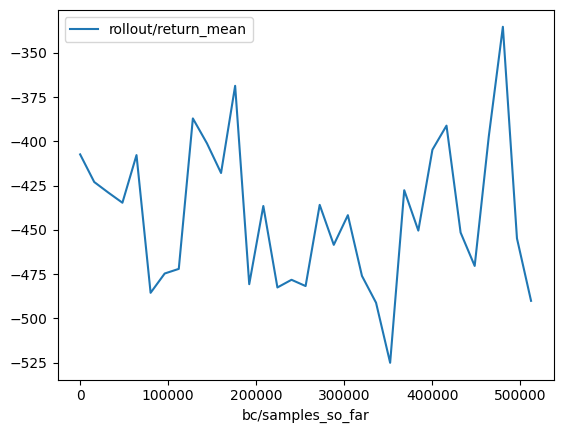

In [9]:
import pandas as pd

df = pd.read_csv(f'{bc_trainer.logger.get_dir()}/progress.csv')
df.plot(y='rollout/return_mean', x='bc/samples_so_far');

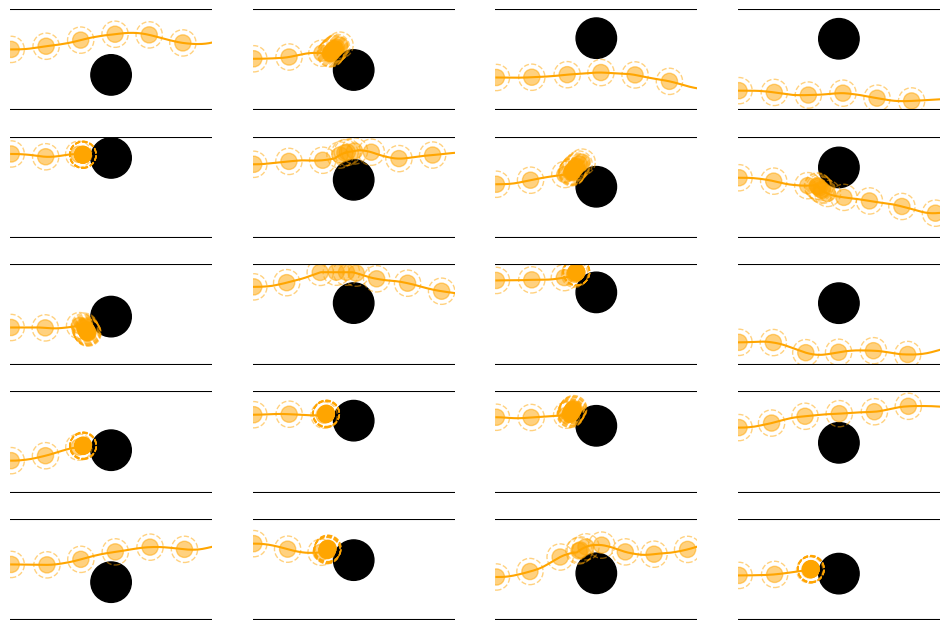

In [10]:
plot_test_runs(policy=bc_trainer.policy, color='orange');

In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

bc_rewards, steps = evaluate_policy(bc_trainer.policy, test_venv, 1000, return_episode_rewards=True)
np.min(bc_rewards),  np.mean(bc_rewards), np.median(bc_rewards), np.max(bc_rewards)

(-670.601806, -359.04048300899996, -415.0369845, -0.272681)

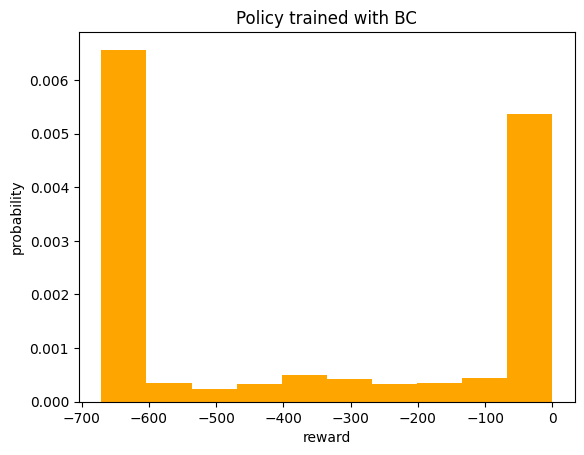

In [12]:
plt.hist(bc_rewards, bins=10, density=True, color="orange");
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with BC");

In [13]:
import pathlib

bc_trainer.save(pathlib.Path(f"{log_folder}/bc/policy"))

## Imitation learning with DAgger

In [14]:
from navground_learning.il import dagger

dagger_trainer = dagger.Trainer(env, log_formats=['tensorboard', 'csv'], log_directory=f"{log_folder}/dagger", 
                                net_arch=[128, 128], parallel=False, n_envs=4,
                                bc_kwargs={'l2_weight': 0, 'ent_weight': 1e-2, 'batch_size': 128})

/Users/jerome.guzzi/Dev/venv/ros_jazzy/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


In [15]:
import time

start = time.time()
dagger_trainer.train(
    total_timesteps=100_000,
    rollout_round_min_episodes=25,
    bc_train_kwargs={
        'log_rollouts_venv': test_venv, 
        'log_rollouts_n_episodes': 50,
        'log_interval': 500,
        'n_epochs': 1,
        'progress_bar': False,
    }
)
print(f'Training took {time.time() - start: .0f} seconds')

/Users/jerome.guzzi/Dev/Others/imitation/src/imitation/data/rollout.py:337: UserWarning: Cannot set deterministic_policy=True when policy is a callable, since deterministic_policy argument is ignored.
  warnings.warn(


Training took  68 seconds


About 60000 steps are enough to learn a decent policy

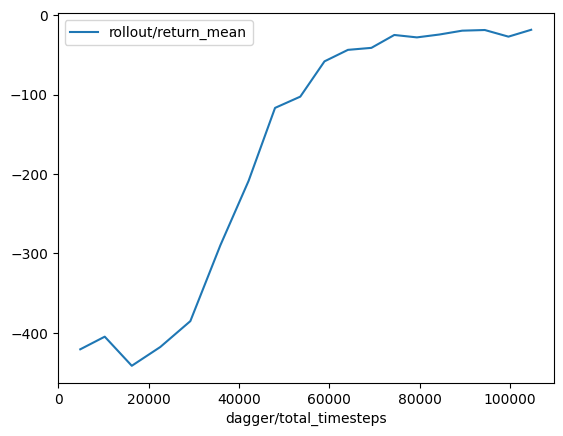

In [16]:
import pandas as pd

df = pd.read_csv(f'{dagger_trainer.logger.get_dir()}/progress.csv')
df = df[df['dagger/total_timesteps'].notna()]
df.plot(y='rollout/return_mean', x='dagger/total_timesteps');

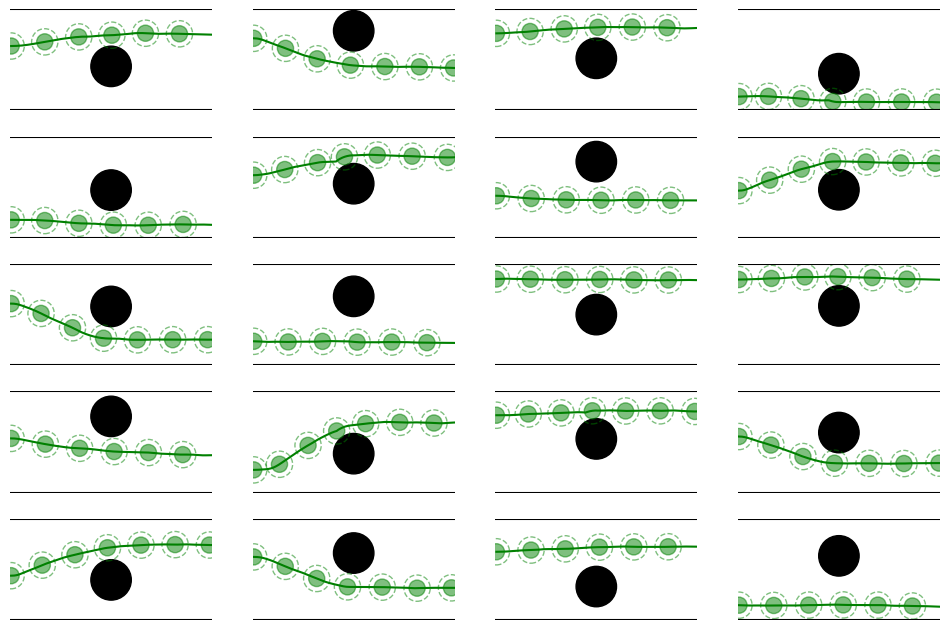

In [17]:
plot_test_runs(policy=dagger_trainer.policy, seed=123, color='green')

In [18]:
from stable_baselines3.common.evaluation import evaluate_policy

dagger_rewards, steps = evaluate_policy(dagger_trainer.policy, test_venv, 1000, return_episode_rewards=True)
np.min(dagger_rewards),  np.mean(dagger_rewards), np.median(dagger_rewards), np.max(dagger_rewards)

(-337.335068, -18.026401288000002, -10.173982, -0.876535)

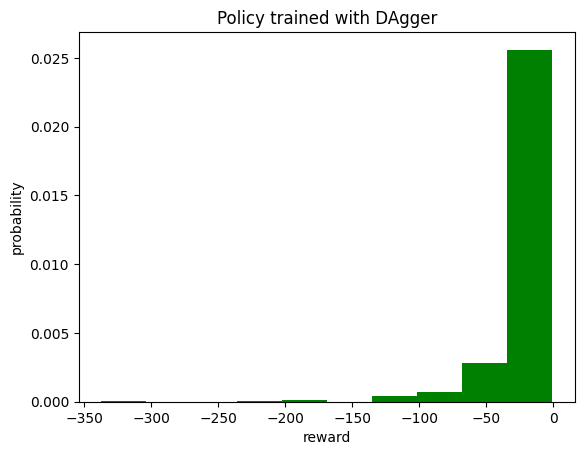

In [19]:
plt.hist(dagger_rewards, bins=10, density=True, color="green");
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with DAgger");

In [20]:
import pathlib

dagger_trainer.save(pathlib.Path(f"{log_folder}/dagger/policy"))

## Reinforcement learning with SAC

In [21]:
from stable_baselines3 import SAC
from stable_baselines3.common.logger import configure

logs = f"{log_folder}/SAC"
model = SAC("MlpPolicy", env, policy_kwargs={'net_arch': [128, 128]})
model.set_logger(configure(logs, ["csv", "tensorboard"]))

In [22]:
import time

start = time.time()
model.learn(total_timesteps=100000, progress_bar=True, tb_log_name="SAC");
print(f'Training took {time.time() - start: .0f} seconds')

Output()

Training took  327 seconds


It learns at good performing policy in about 50000 steps. It takes about 5x longer compared to Dagger but the policy is also better, especialy the worst case.

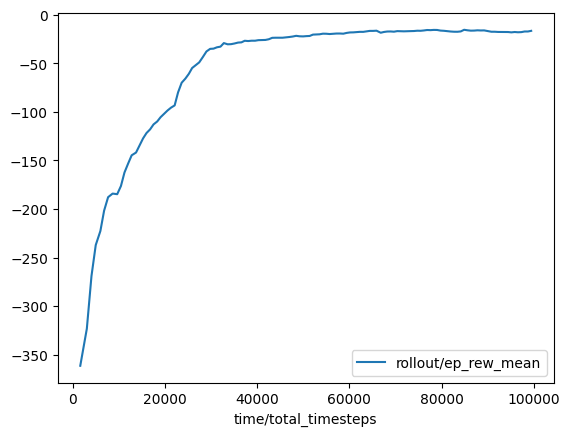

In [23]:
import pandas as pd

df = pd.read_csv(f'{logs}/progress.csv')
df.plot(y='rollout/ep_rew_mean', x='time/total_timesteps');

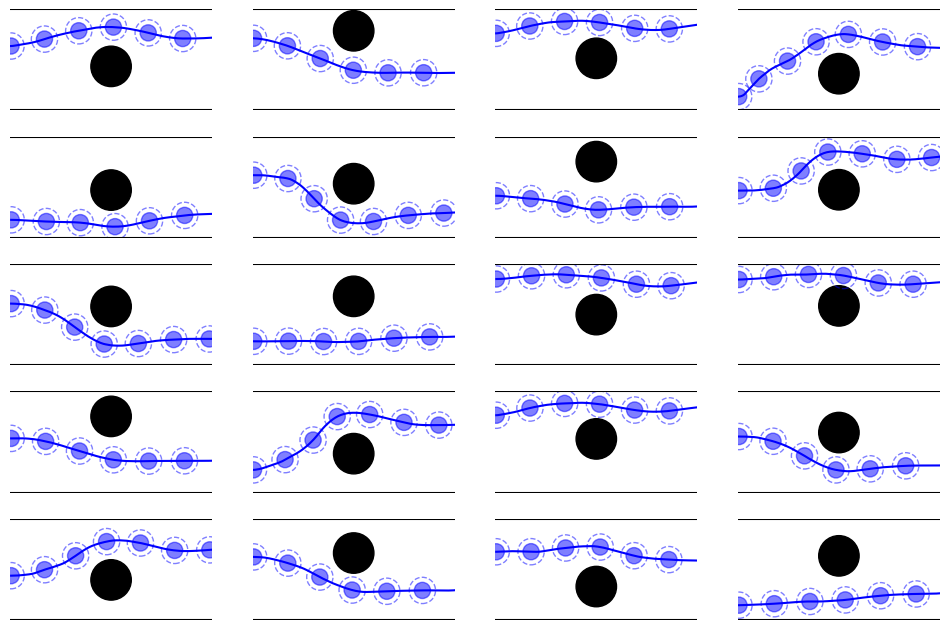

In [24]:
plot_test_runs(policy=model.policy, seed=123, color='blue') 

In [25]:
from stable_baselines3.common.evaluation import evaluate_policy

sac_rewards, steps = evaluate_policy(model.policy, test_venv, 1000, return_episode_rewards=True)
np.min(sac_rewards),  np.mean(sac_rewards), np.median(sac_rewards), np.max(sac_rewards)

(-41.496797, -9.957440417, -7.724690000000001, -2.222684)

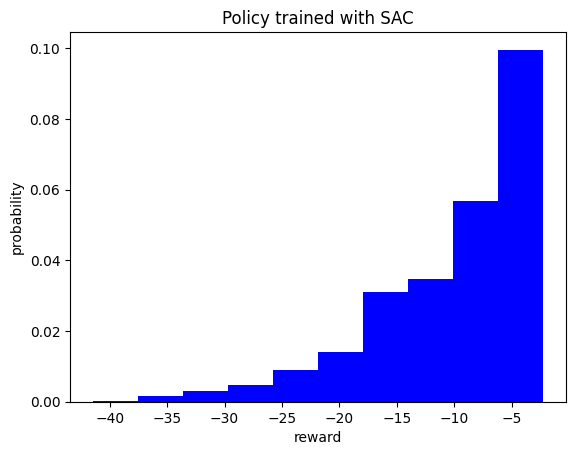

In [26]:
plt.hist(sac_rewards, bins=10, density=True, color='blue');
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with SAC");

In [27]:
model.save(f"{logs}/model")

## Comparision with HL

In [28]:
hl_rewards = evaluate_expert(env.unwrapped, runs=1000, seed=0)

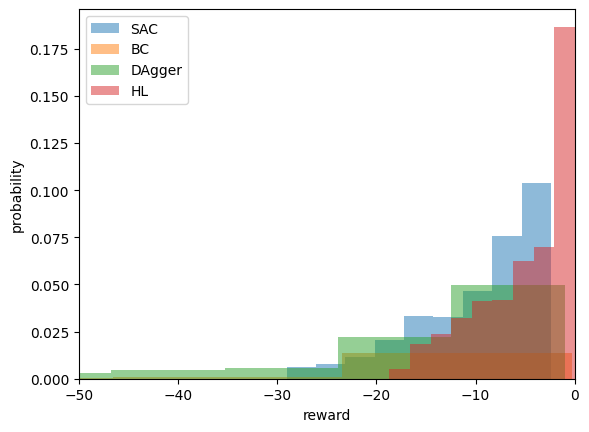

In [29]:
plt.hist(sac_rewards, bins=np.linspace(np.quantile(sac_rewards, 0.02), np.quantile(sac_rewards, 0.98), 10), density=True, label="SAC", alpha=0.5)
plt.hist(bc_rewards, bins=np.linspace(np.quantile(bc_rewards, 0.02), np.quantile(bc_rewards, 0.98), 30), density=True, label="BC", alpha=0.5)
plt.hist(dagger_rewards, bins=np.linspace(np.quantile(dagger_rewards, 0.02), np.quantile(dagger_rewards, 0.98), 10), density=True, label="DAgger", alpha=0.5)
plt.hist(hl_rewards, bins=np.linspace(np.quantile(hl_rewards, 0.02), np.quantile(hl_rewards, 0.98), 10), density=True, label="HL", alpha=0.5)
plt.xlabel('reward')
plt.ylabel('probability');
plt.xlim(-50, 0)
plt.legend();

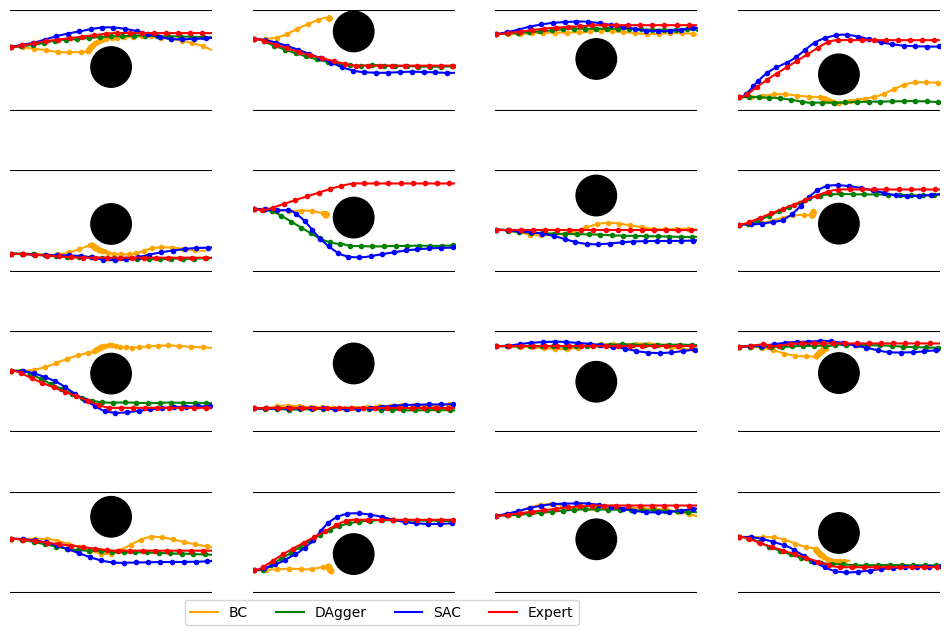

In [30]:
plot_comparison_test_runs(policies=((bc_trainer.policy, 'orange', 'BC'), 
                                    (dagger_trainer.policy, 'green', 'DAgger'), 
                                    (model.policy, 'blue', 'SAC'),
                                    (None, 'red', 'Expert')), seed=123, step=10, cols=4, rows=4)
plt.legend(bbox_to_anchor=(-.75, 0), ncols=4);